In [2]:
# try to mount google colab
import os
try:
  from google.colab import drive
  drive.mount('/content/drive')
  cur_dir = "/content/drive/MyDrive/ws/prj/adv_ds_2310/Lab05_Models/ex01_iris_classification/models"
except:
  cur_dir = "."
  pass
cur_dir = os.path.abspath(cur_dir)
os.chdir(cur_dir)

print(f'cur_dir: {cur_dir} \n --> {os.path.abspath(".")}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cur_dir: /content/drive/MyDrive/ws/prj/adv_ds_2310/Lab05_Models/ex01_iris_classification/models 
 --> /content/drive/MyDrive/ws/prj/adv_ds_2310/Lab05_Models/ex01_iris_classification/models


# Phân loại loài hoa Iris (Thực nghiệm)

## Ôn tập (Review)

Trong phần trước, chúng ta đã tiến hành các bước sau:
1. Định nghĩa vấn đề
    + Mô tả vấn đề
    + Xác định đầu vào, đầu ra, loại bài toán
2. Chuẩn bị vấn đề:
    + Tải thư viện và dữ liệu
3. Phân tích dữ liệu:
    + Hiển thị thông tin dữ liệu
    + Thông tin thống kê trên các thuộc tính dữ liệu
    + Mối tương quan giữa các thuộc tính
5. Chia dữ liệu
6. Chuẩn bị dữ liệu:
    + Làm sạch dữ liệu (tạo bảng dữ liệu chỉ có thuộc tính nhập, xuất, xử lý dữ liệu thiếu và trùng lặp)
    + Biến đổi dữ liệu (label encoder, onehot encoder, chuẩn hóa)

**Kết quả**:
+ exps/data:
  + train.xlsx
  + test.xls
+ feature1:
  
  + scale_columns.npz (chứa cột biến đổi)
  + class_encoder.joblib
  
  + Feature MinMax:
    + minmax_scaler.joblib
    + feat_minmax.npz
    + df_minmax.xlsx
  
  + Feature Standard:
    + standard_scaler.joblib
    + feat_standard.npz
    + df_standard.xlsx

## Khởi tạo thí nghiệm

### Khai báo thư viện

In [64]:
# Load libraries
import os, sys
from IPython import display
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import ticker

import pandas as pd
import seaborn as sns
import joblib
import pprint
import random

# preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# model selection
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold

# algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
import sklearn

# metrics
from sklearn.metrics import accuracy_score , ConfusionMatrixDisplay, confusion_matrix

import warnings

%matplotlib inline
# plt.rcParams["figure.figsize"] = (12, 6)
# plt.rcParams['figure.dpi'] = 100

warnings.filterwarnings("ignore")

### Tham số thực nghiệm

In [5]:
params = {}

params["exps_dir"]  = "../exps"
params["exp_name"]  = "iris_classification_02_standard"

params["exps_root"] = f'{params["exps_dir"]}/result1_standard'
params["save_dir"]  = f'{params["exps_dir"]}/result1_{params["exp_name"]}'

params["class_encoder_path"] = f'{params["exps_dir"]}/feature1/class_encoder.joblib'

params["data_path"]  = f'{params["exps_dir"]}/feature1/df_standard.xlsx'

# params["data_path"]  = f'{params["exps_root"]}/df_clean.xlsx'
# params["exps_name"]  = "iris_classification_02_clean"

# params["data_path"]  = f'{params["exps_root"]}/df_clean_minmax.xlsx'
# params["exps_name"]  = "iris_classification_02_minmax"

params["k_fold"] = 5
params["random_state"] = 42

print("params: ")
for k in params: print(f'+ {k}: {params[k]}')

# cố định random-state để phục hồi lại kết quả thí nghiệm
random.seed(params["random_state"])
os.environ['PYTHONHASHSEED'] = str(params["random_state"])
np.random.seed(params["random_state"])

params: 
+ exps_dir: ../exps
+ exp_name: iris_classification_02_standard
+ exps_root: ../exps/result1_standard
+ save_dir: ../exps/result1_iris_classification_02_standard
+ class_encoder_path: ../exps/feature1/class_encoder.joblib
+ data_path: ../exps/feature1/df_standard.xlsx
+ data_split_train: 0.7
+ k_fold: 5
+ random_state: 42


## 5. Dữ liệu kiểm nghiệm (Validation Dataset)

Chúng ta chuẩn bị dữ liệu kiểm nghiệm theo phương pháp hold-out:
+ Tập dữ liệu được chia thành 2 phần train/test với tỉ lệ 7/3 (đã làm trước)
+ Tập train sẽ được dùng để huấn luyện, điều chỉnh tham số với chiến lược:
    + Hold-out (tiếp tục chia 7/3 với train/valid)
    + k-fold (chia thành k phần đều nhau với k-1 phần cho train/1 phần cho valid)
    + Trong đó, train là dùng huấn luyện và valid dùng điều chỉnh tham số
+ Tập test dùng để kiểm nghiệm lại độ hiệu quả của thuật toán sau khi chọn mô hình tối ưu

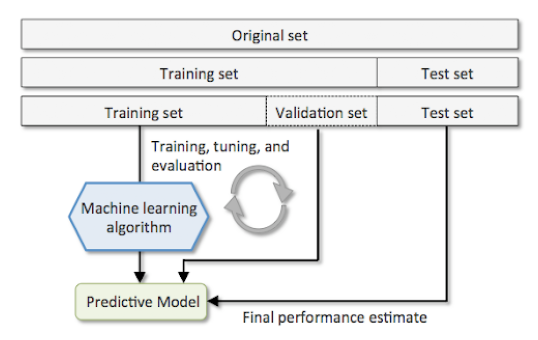

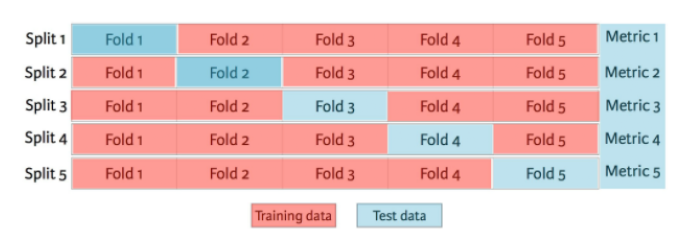

In [ ]:
plt.figure(figsize=(12,6)); plt.imshow(plt.imread("holdout.png")); plt.axis("off");
plt.figure(figsize=(12,6)); plt.imshow(plt.imread("kfold.png")); plt.axis("off");

In [6]:
# Tải thông tin dữ liệu
df_data   = pd.read_excel(params["data_path"])

print(f'Data path [{params["data_path"]}]')
display.display(df_data)

Data path [../exps/feature1/df_standard.xlsx]


,sepal-length,sepal-width,petal-length,petal-width,class
0,0.411765,0.409091,0.553571,0.500000,1
1,0.970588,0.454545,0.982143,0.833333,2
2,0.382353,0.454545,0.607143,0.583333,1
3,0.235294,0.681818,0.053571,0.041667,0
4,1.000000,0.363636,1.000000,0.791667,2
...,...,...,...,...,...
94,0.529412,0.363636,0.517857,0.500000,1
95,0.176471,0.227273,0.607143,0.666667,2
96,0.441176,0.909091,0.017857,0.041667,0
97,0.441176,0.272727,0.517857,0.458333,1


In [9]:
# Chia dữ liệu thành trường input/output
X_train, y_train = df_data.values[:, :-1], df_data.values[:, -1].astype(np.int)

In [10]:
print(f'+ x_shape: {X_train.shape}, y_shape: {y_train.shape}')
print(f'+ Input:\n{X_train[:20, :]}')
print(f'+ Output:\n{y_train[:20]}')

+ x_shape: (99, 4), y_shape: (99,)
+ Input:
[[0.41176471 0.40909091 0.55357143 0.5       ]
 [0.97058824 0.45454545 0.98214286 0.83333333]
 [0.38235294 0.45454545 0.60714286 0.58333333]
 [0.23529412 0.68181818 0.05357143 0.04166667]
 [1.         0.36363636 1.         0.79166667]
 [0.44117647 0.31818182 0.53571429 0.375     ]
 [0.26470588 0.63636364 0.05357143 0.04166667]
 [0.20588235 0.68181818 0.03571429 0.08333333]
 [0.23529412 0.81818182 0.14285714 0.125     ]
 [0.20588235 0.         0.42857143 0.375     ]
 [0.58823529 0.31818182 0.67857143 0.70833333]
 [0.14705882 0.63636364 0.14285714 0.04166667]
 [0.20588235 0.45454545 0.08928571 0.04166667]
 [0.23529412 0.59090909 0.10714286 0.16666667]
 [0.38235294 0.31818182 0.55357143 0.5       ]
 [0.23529412 0.63636364 0.07142857 0.04166667]
 [0.41176471 0.45454545 0.55357143 0.45833333]
 [1.         0.81818182 1.         0.875     ]
 [0.08823529 0.54545455 0.05357143 0.04166667]
 [0.55882353 0.40909091 0.57142857 0.5       ]]
+ Output:
[1 2 

## 6. Lượng giá thuật toán (Evaluate Algorithms)

### 6.1. Baselines

In [12]:
kfold = KFold(n_splits=params["k_fold"], shuffle=True, random_state=params["random_state"])
print(f"+ X_train: {len(X_train)}")
for fold, (train_idx, valid_idx) in enumerate(kfold.split(X_train, y_train)):
    print(f'Fold {fold}: ')
    print(f'+ train_idx: {train_idx}')
    print(f'+ valid_idx: {valid_idx}')
    print(f'+ train / valid: {valid_idx}')
    pass

+ X_train: 99
Fold 0: 
+ train_idx: [ 1  2  3  5  6  7  8  9 11 13 14 15 16 17 19 20 21 23 24 25 27 28 29 30
 32 33 34 35 36 37 38 39 41 43 45 46 48 49 50 51 52 53 54 55 56 57 58 59
 60 61 63 65 66 67 68 69 70 71 72 74 75 77 78 79 80 81 82 83 85 86 87 89
 90 91 92 93 94 96 98]
+ valid_idx: [ 0  4 10 12 18 22 26 31 40 42 44 47 62 64 73 76 84 88 95 97]
+ train / valid: [ 0  4 10 12 18 22 26 31 40 42 44 47 62 64 73 76 84 88 95 97]
Fold 1: 
+ train_idx: [ 0  1  2  3  4  6  7  8 10 12 13 14 17 18 19 20 21 22 23 24 25 26 27 29
 31 32 34 36 37 38 40 41 42 43 44 46 47 48 50 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 66 67 71 73 74 75 76 77 78 79 80 82 83 84 85 86 87 88 90
 91 92 93 95 96 97 98]
+ valid_idx: [ 5  9 11 15 16 28 30 33 35 39 45 49 65 68 69 70 72 81 89 94]
+ train / valid: [ 5  9 11 15 16 28 30 33 35 39 45 49 65 68 69 70 72 81 89 94]
Fold 2: 
+ train_idx: [ 0  1  2  4  5  9 10 11 12 14 15 16 18 20 21 22 23 26 28 29 30 31 32 33
 35 37 39 40 41 42 43 44 45 46 47 48 49 50 51 52 54 57 

In [13]:
X_train[[0, 2, 10]]

array([[0.41176471, 0.40909091, 0.55357143, 0.5       ],
       [0.38235294, 0.45454545, 0.60714286, 0.58333333],
       [0.58823529, 0.31818182, 0.67857143, 0.70833333]])

In [14]:
y_train[[0,2,10]]

array([1, 1, 2])

In [28]:
# Mô hình mặc định (models, results, hyper-parameters)
baseline_models  = {}
baseline_results = {}

# khởi tạo các tham số mặc định
baseline_models['LR']   = LogisticRegression(random_state=params["random_state"])
baseline_models['LDA']  = LinearDiscriminantAnalysis()
baseline_models['KNN']  = KNeighborsClassifier()
baseline_models['CART'] = DecisionTreeClassifier(random_state=params["random_state"])
baseline_models['NB']   = GaussianNB()
baseline_models['SVM']  = SVC(random_state=params["random_state"])

# Huấn luyện từng mô hình cơ sở
for model_name in baseline_models:

    baseline_results[model_name] = []

    print(f'Model [{model_name}]:')

    # Chiến lược chia dữ liệu trên tập X_train
    kfold = KFold(n_splits=params["k_fold"], shuffle=True, random_state=params["random_state"])

    # Tách X_train, y_train thành 2 tập train, valid trên từng fold
    # Với mỗi fold, train cho huấn luyện, valid cho lượng giá và điều chỉnh tham số
    for fold, (train_idx, valid_idx) in enumerate(kfold.split(X_train, y_train)):
        # Chia 2 tập thành train/valid
        X1_train, y1_train = X_train[train_idx], y_train[train_idx]
        X1_valid, y1_valid = X_train[valid_idx], y_train[valid_idx]


        # Lấy mô hình khởi tạo
        model_clf = sklearn.base.clone(baseline_models[model_name])

        # Huấn luyện mô hình
        model_clf.fit(X1_train, y1_train)

        # Lượng giá mô hình
        y1_pred_valid = model_clf.predict(X1_valid)

        # Tính toán metrics: accuracy
        valid_acc = accuracy_score(y1_valid, y1_pred_valid)

        # Lưu metrics trên từng fold
        baseline_results[model_name].append(valid_acc)

        pass # fold
    # Chúng ta đơn giản sử dụng lệnh bên dưới thay cho khối lệnh k-fold bên trên
    # baseline_results[name] = cross_val_score(model_clf, X_train, y_train, cv = kfold, scoring="accuracy")

    # hiển thị tham số mô hình
    print(f'+ params = {baseline_models[model_name].get_params()}')

    # hiển thị kết quả trên từng fold
    print(f'+ acc = {baseline_results[model_name]}')

    # trung bình kết quả +/ std cho tất cả các fold,
    # std: độ lệch chuẩn=> nếu cùng mean thì độ lệch nào nhỏ hơn thì tốt hơn vì ổn định và tập trung hơn
    s_msg = f'+ mean_acc = {np.mean(baseline_results[model_name]):.6f} +/- {np.std(baseline_results[model_name]):.6f}'
    print(s_msg)
    print()

    # Huấn luyện lại với trên toàn bộ dữ liệu train (re-fit all train_data)
    baseline_models[model_name].fit(X_train, y_train)
    pass # model

Model [LR]:
+ params = {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
+ acc = [0.85, 0.9, 0.95, 0.85, 1.0]
+ mean_acc = 0.910000 +/- 0.058310

Model [LDA]:
+ params = {'covariance_estimator': None, 'n_components': None, 'priors': None, 'shrinkage': None, 'solver': 'svd', 'store_covariance': False, 'tol': 0.0001}
+ acc = [0.95, 0.95, 1.0, 1.0, 1.0]
+ mean_acc = 0.980000 +/- 0.024495

Model [KNN]:
+ params = {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
+ acc = [0.9, 0.95, 0.95, 0.9, 1.0]
+ mean_acc = 0.940000 +/- 0.037417

Model [CART]:
+ params = {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nod

In [34]:
# Mô hình mặc định (models, results, hyper-parameters)
baseline_models  = {}
baseline_results = {}

# khởi tạo các tham số mặc định
baseline_models['LR']   = LogisticRegression(random_state=params["random_state"])
baseline_models['LDA']  = LinearDiscriminantAnalysis()
baseline_models['KNN']  = KNeighborsClassifier()
baseline_models['CART'] = DecisionTreeClassifier(random_state=params["random_state"])
baseline_models['NB']   = GaussianNB()
baseline_models['SVM']  = SVC(random_state=params["random_state"])

# Huấn luyện từng mô hình cơ sở
for model_name in baseline_models:

    baseline_results[model_name] = []

    print(f'Model [{model_name}]:')

    # Chiến lược chia dữ liệu trên tập X_train
    kfold = KFold(n_splits=params["k_fold"], shuffle=True, random_state=params["random_state"])

    # Lấy mô hình khởi tạo
    model_clf = sklearn.base.clone(baseline_models[model_name])

    # Chúng ta đơn giản sử dụng lệnh bên dưới thay cho khối lệnh k-fold bên trên
    baseline_results[model_name] = cross_val_score(model_clf, X_train, y_train, cv = kfold, scoring="accuracy")

    # hiển thị tham số mô hình
    print(f'+ params = {baseline_models[model_name].get_params()}')

    # hiển thị kết quả trên từng fold
    print(f'+ acc = {baseline_results[model_name]}')

    # trung bình kết quả +/ std cho tất cả các fold,
    # std: độ lệch chuẩn=> nếu cùng mean thì độ lệch nào nhỏ hơn thì tốt hơn vì ổn định và tập trung hơn
    s_msg = f'+ mean_acc = {np.mean(baseline_results[model_name]):.6f} +/- {np.std(baseline_results[model_name]):.6f}'
    print(s_msg)
    print()

    # Huấn luyện lại với trên toàn bộ dữ liệu train (re-fit all train_data)
    baseline_models[model_name].fit(X_train, y_train)
    pass # model

Model [LR]:
+ params = {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
+ acc = [0.85 0.9  0.95 0.85 1.  ]
+ mean_acc = 0.910000 +/- 0.058310

Model [LDA]:
+ params = {'covariance_estimator': None, 'n_components': None, 'priors': None, 'shrinkage': None, 'solver': 'svd', 'store_covariance': False, 'tol': 0.0001}
+ acc = [0.95 0.95 1.   1.   1.  ]
+ mean_acc = 0.980000 +/- 0.024495

Model [KNN]:
+ params = {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
+ acc = [0.9  0.95 0.95 0.9  1.  ]
+ mean_acc = 0.940000 +/- 0.037417

Model [CART]:
+ params = {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes':

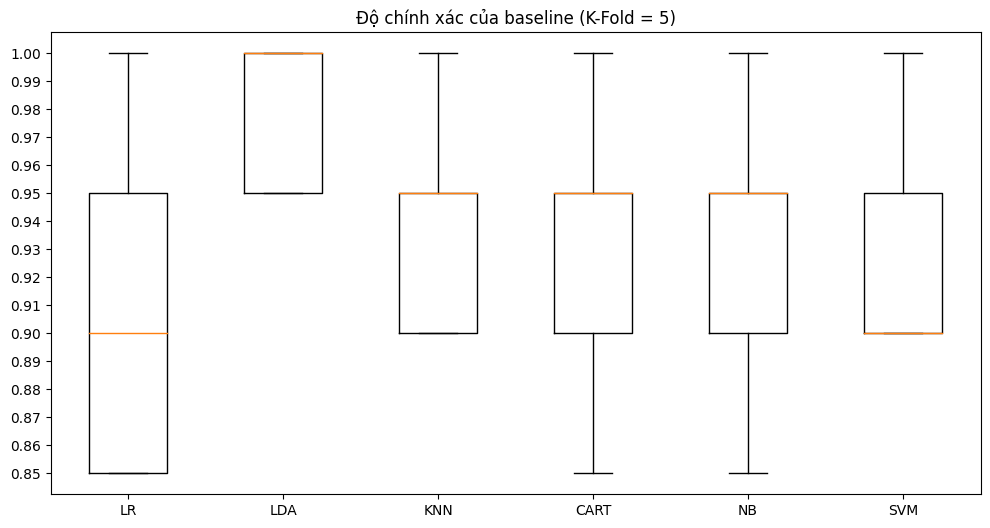

In [35]:
# In biểu đồ box-plot trên độ chính xác với k-fold
plt.figure(figsize=(12,6))
plt.boxplot(baseline_results.values())
plt.gca().set_xticklabels(baseline_results.keys())
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.01))
plt.title(f'Độ chính xác của baseline (K-Fold = {params["k_fold"]})')
plt.show()

### 6.2. Tinh chỉnh mô hình (Tuning Models)

In [36]:
tunning_results = {
    "best_clf"   : {},
    "best_score" : {},
}

tunning_models  = {}
tunning_params  = {}

# khởi tạo các tham số mặc định
tunning_models['KNN']  = KNeighborsClassifier()
tunning_params['KNN']  = {
    'n_neighbors': [2, 4, 6, 8, 10],
}

tunning_models['SVM']  = SVC(decision_function_shape = 'ovr',
                             class_weight = 'balanced',
                             probability  = True,
                             random_state = params["random_state"])
tunning_params['SVM']  = {
    'kernel': ['linear', 'rbf'], # 'sigmoid', 'poly'
    'C': [1, 10, 100,200], # 50, 70
    'gamma': [1e-3, 1e-2], # 1e-4
}

for model_name in tunning_models:
    model_clf = tunning_models[model_name]

    print(f'Model [{model_name}]:')

    kfold = KFold(n_splits=params["k_fold"], shuffle=True, random_state=params["random_state"])

    grid_clf = GridSearchCV(estimator=model_clf,
                            param_grid=tunning_params[model_name],
                            cv = kfold, scoring="accuracy")
    grid_result = grid_clf.fit(X_train, y_train)

    # store best model
    tunning_results["best_clf"][model_name] = grid_clf.best_estimator_

    # get search results
    tunning_results["best_score"][model_name] = grid_result.best_score_


    # information
    print(f'+ Best score: {grid_result.best_score_}')
    print(f'+ Best turnning params: {grid_result.best_params_}')
    print(f'+ Best full params: {grid_clf.best_estimator_.get_params()}')
    print()

    pass

Model [KNN]:
+ Best score: 0.95
+ Best turnning params: {'n_neighbors': 4}
+ Best full params: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 4, 'p': 2, 'weights': 'uniform'}

Model [SVM]:
+ Best score: 0.97
+ Best turnning params: {'C': 10, 'gamma': 0.001, 'kernel': 'linear'}
+ Best full params: {'C': 10, 'break_ties': False, 'cache_size': 200, 'class_weight': 'balanced', 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.001, 'kernel': 'linear', 'max_iter': -1, 'probability': True, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False}



## 7. Kiểm nghiệm kết quả trên Test (Finalize Model)

### Load và tiền xử lý tập test

In [47]:
# Load
df_test = pd.read_excel(f'{params["exps_dir"]}/data/test.xlsx')
print("Test: ", len(df_test))
display.display(df_test.head())

Test:  50


,sepal-length,sepal-width,petal-length,petal-width,class
0,6.1,2.8,4.7,1.2,Iris-versicolor
1,5.7,3.8,1.7,0.3,Iris-setosa
2,7.7,2.6,6.9,2.3,Iris-virginica
3,6.0,2.9,4.5,1.5,Iris-versicolor
4,6.8,2.8,4.8,1.4,Iris-versicolor


In [48]:
# Class Encoder
class_encoder = joblib.load(f'{params["exps_dir"]}/feature1/class_encoder.joblib')
df_test["class"] = class_encoder.transform(df_test['class'])
display.display(df_test.head())

,sepal-length,sepal-width,petal-length,petal-width,class
0,6.1,2.8,4.7,1.2,1
1,5.7,3.8,1.7,0.3,0
2,7.7,2.6,6.9,2.3,2
3,6.0,2.9,4.5,1.5,1
4,6.8,2.8,4.8,1.4,1


In [56]:
# Standard Encoder
standard_scaler = joblib.load(f'{params["exps_dir"]}/feature1/standard_scaler.joblib')
display.display(standard_scaler.__dict__)

scale_columns = dict(np.load(f'{params["exps_dir"]}/feature1/scale_columns.npz'))['scale_columns']
print(scale_columns)


{'with_mean': True,
 'with_std': True,
 'copy': True,
 'feature_names_in_': array(['sepal-length', 'sepal-width', 'petal-length', 'petal-width'],
       dtype=object),
 'n_features_in_': 4,
 'n_samples_seen_': 99,
 'mean_': array([5.82424242, 3.00505051, 3.84040404, 1.22929293]),
 'var_': array([0.68931129, 0.1730048 , 2.95473115, 0.54772778]),
 'scale_': array([0.83024773, 0.41593845, 1.71893314, 0.74008633])}

['sepal-length' 'sepal-width' 'petal-length' 'petal-width']


In [57]:
df_test[scale_columns] = standard_scaler.transform(df_test[scale_columns])
display.display(df_test.head())

,sepal-length,sepal-width,petal-length,petal-width,class
0,0.332139,-0.492983,0.500075,-0.039580,1
1,-0.149645,1.911219,-1.245193,-1.255655,0
2,2.259275,-0.973823,1.779939,1.446733,2
3,0.211693,-0.252563,0.383724,0.365778,1
4,1.175261,-0.492983,0.558251,0.230658,1


In [58]:
# Chia dữ liệu thành trường input/output
X_test, y_test = df_test.values[:, :-1], df_test.values[:, -1].astype(np.int)

## Đánh giá Baseline

In [67]:
class_encoder.classes_

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

Baseline [LR]
+ acc = 0.860


array([[19,  0,  0],
       [ 2, 13,  0],
       [ 0,  5, 11]])

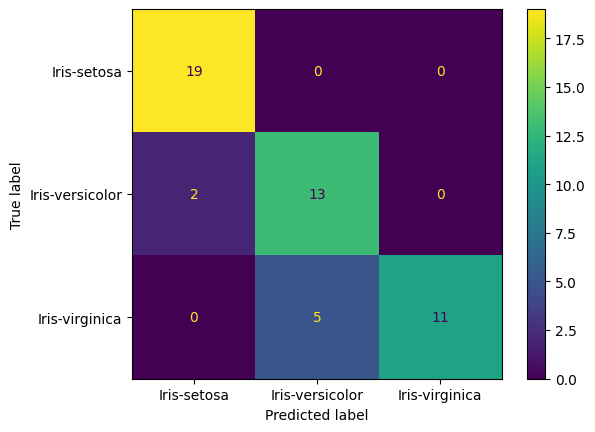

Baseline [LDA]
+ acc = 0.940


array([[19,  0,  0],
       [ 2, 12,  1],
       [ 0,  0, 16]])

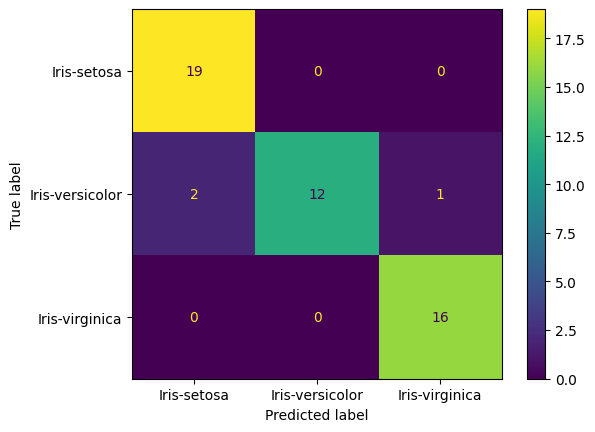

Baseline [KNN]
+ acc = 0.900


array([[19,  0,  0],
       [ 2, 13,  0],
       [ 0,  3, 13]])

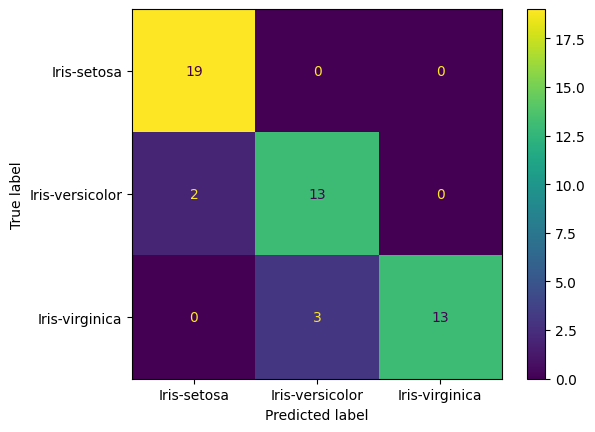

Baseline [CART]
+ acc = 0.920


array([[19,  0,  0],
       [ 4, 11,  0],
       [ 0,  0, 16]])

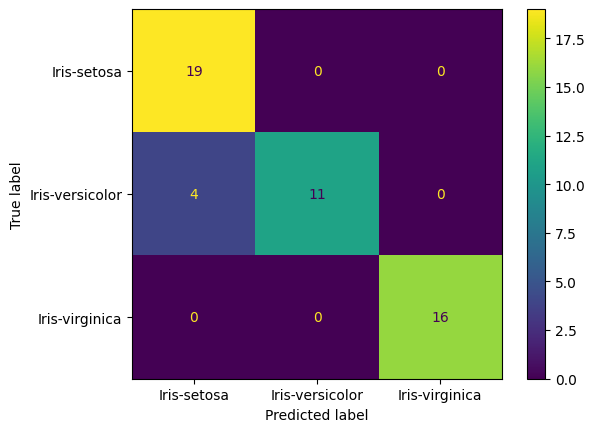

Baseline [NB]
+ acc = 0.500


array([[ 0,  0, 19],
       [ 4, 11,  0],
       [ 0,  2, 14]])

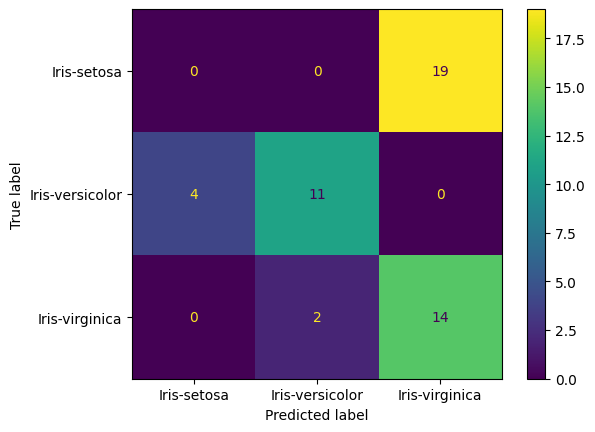

Baseline [SVM]
+ acc = 0.480


array([[ 0,  0, 19],
       [ 2,  9,  4],
       [ 0,  1, 15]])

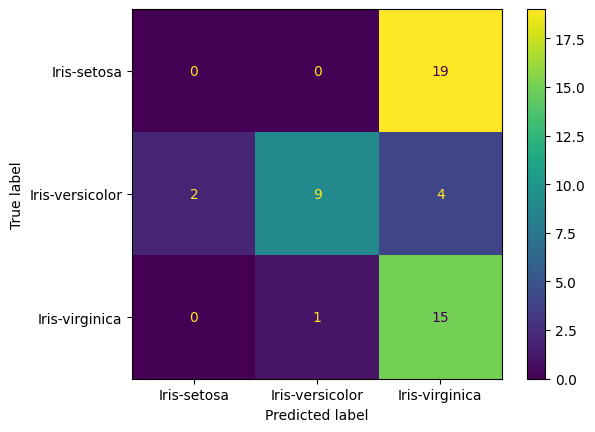

In [69]:
test_models  = {}
test_scores  = {}

# Kiểm tra kết quả trên tập test (baseline)
for model_name in baseline_models:
    model_clf = baseline_models[model_name]
    y_pred_test = model_clf.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred_test)

    # information
    print(f'Baseline [{model_name}]')
    print(f'+ acc = {test_acc:.3f}')

    cm = confusion_matrix(y_test, y_pred_test)
    display.display(cm)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_encoder.classes_)
    disp.plot()

    plt.show()

Tunning [KNN]
+ acc = 0.880


array([[19,  0,  0],
       [ 2, 13,  0],
       [ 0,  4, 12]])

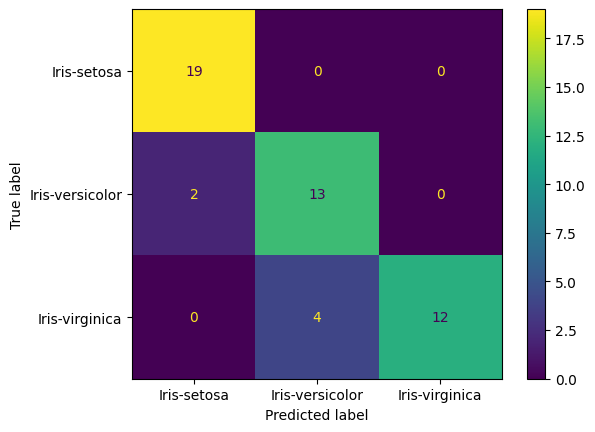

Tunning [SVM]
+ acc = 0.900


array([[19,  0,  0],
       [ 4, 10,  1],
       [ 0,  0, 16]])

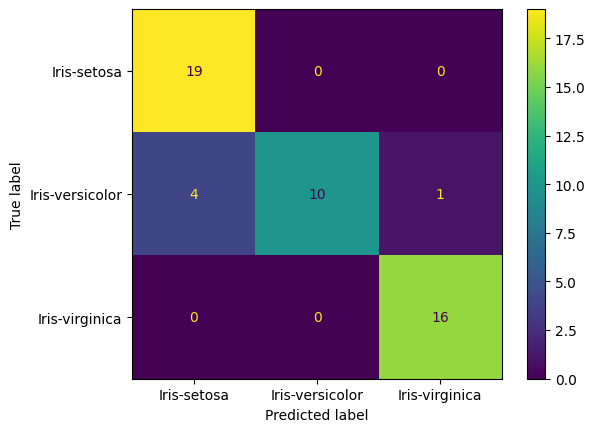

In [70]:
# Kiểm tra kết quả trên tập test (baseline)
for model_name in tunning_models:
    model_clf = tunning_results["best_clf"][model_name]
    y_pred_test = model_clf.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred_test)

    # information
    print(f'Tunning [{model_name}]')
    print(f'+ acc = {test_acc:.3f}')

    cm = confusion_matrix(y_test, y_pred_test)
    display.display(cm)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_encoder.classes_)
    disp.plot()

    plt.show()

## 8. Lưu kết quả thí nghiệm

In [71]:
save_dir = params["save_dir"]
!jupyter nbconvert $cur_dir/model1.ipynb \
    --to html \
    --output-dir $save_dir \
    --output model1

[NbConvertApp] Converting notebook /content/drive/MyDrive/ws/prj/adv_ds_2310/Lab05_Models/ex01_iris_classification/models/model1.ipynb to html
[NbConvertApp] Writing 1167039 bytes to ../exps/result1_iris_classification_02_standard/model1.html


# Kết thúc